In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
path = os.getcwd()
train_dir = os.path.join(path, "Datasets/HAM10000_images/train")
val_dir = os.path.join(path, "Datasets/HAM10000_images/val")
test_dir = os.path.join(path, "Datasets/HAM10000_images/test")

In [14]:
# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2,1.0], 
    channel_shift_range=50.0 
)


# No Data Augmentation for Validation and Test Set
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load validation data
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 7007 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
Found 1509 images belonging to 7 classes.


In [16]:
# Calculate number of training, validation, and test samples
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples
num_test_samples = test_generator.samples

# Calculate number of classes
num_classes = len(train_generator.class_indices)

# Define class labels
class_labels = list(train_generator.class_indices.keys())

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=15,verbose=0)


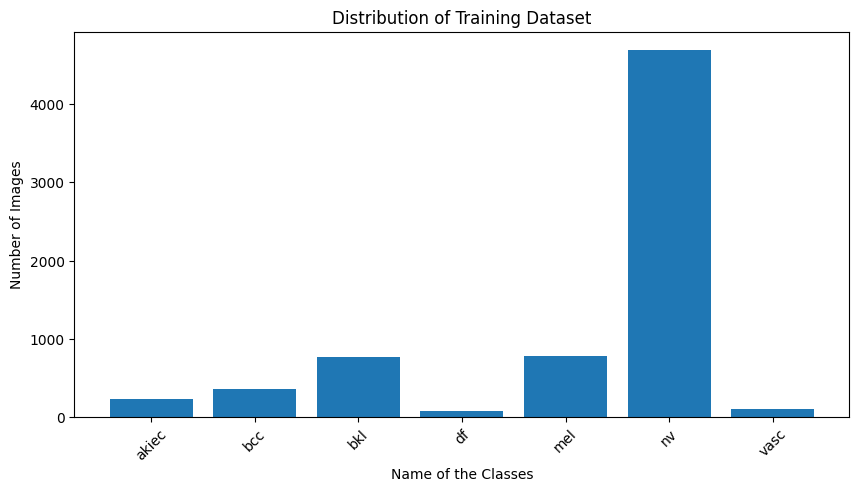

In [17]:
import matplotlib.pyplot as plt

# Calculate class distribution for training data
train_class_distribution = train_generator.classes
train_class_distribution = [train_class_distribution.tolist().count(i) for i in range(num_classes)]

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(class_labels, train_class_distribution)
plt.title('Distribution of Training Dataset')
plt.xlabel('Name of the Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

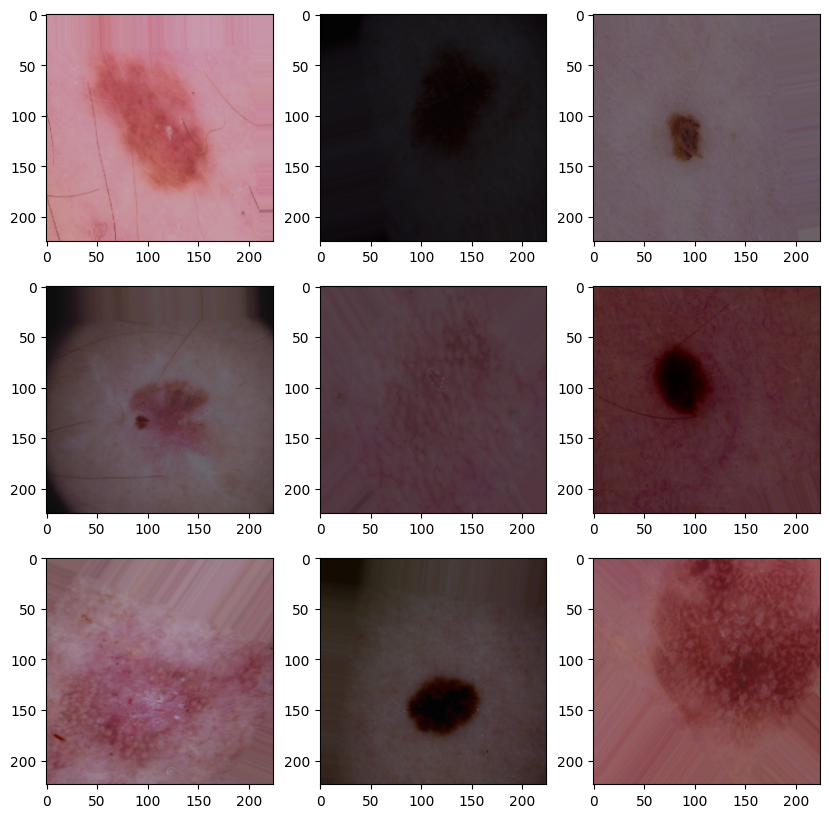

In [18]:
# Get a batch of images from the train_generator
x_batch, y_batch = train_generator.next()

# Plot 9 images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
plt.show()

In [19]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

# Compile the CNN model
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model
history_cnn = model_cnn.fit(train_generator,
                            steps_per_epoch=num_train_samples // batch_size,
                            epochs=100,
                            validation_data=val_generator,
                            validation_steps=num_val_samples // batch_size,
                            callbacks=[early_stopping,reduce_lr])

Epoch 1/100
218/218 [==============================] - 176s 771ms/step - loss: 1.6047 - accuracy: 0.4905 - val_loss: 1.3458 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 2/100
218/218 [==============================] - 106s 485ms/step - loss: 1.1237 - accuracy: 0.6333 - val_loss: 1.1270 - val_accuracy: 0.6182 - lr: 0.0010
Epoch 3/100
218/218 [==============================] - 106s 484ms/step - loss: 1.0298 - accuracy: 0.6556 - val_loss: 1.1404 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 4/100
218/218 [==============================] - 106s 484ms/step - loss: 1.0011 - accuracy: 0.6589 - val_loss: 1.1171 - val_accuracy: 0.5897 - lr: 0.0010
Epoch 5/100
218/218 [==============================] - 104s 475ms/step - loss: 0.9600 - accuracy: 0.6668 - val_loss: 0.8918 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 6/100
218/218 [==============================] - 103s 474ms/step - loss: 0.9380 - accuracy: 0.6707 - val_loss: 1.0981 - val_accuracy: 0.6692 - lr: 0.0010
Epoch 7/100
218/218 [===================

In [20]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 111, 111, 64)     256       
 hNormalization)                                                 
                                                        

In [21]:
# Evaluate CNN model
score_cnn = model_cnn.evaluate(test_generator, steps=num_test_samples // batch_size, verbose=0)
print('CNN Test loss:', score_cnn[0])
print('CNN Test accuracy:', score_cnn[1])

CNN Test loss: 0.6078146696090698
CNN Test accuracy: 0.7739361524581909


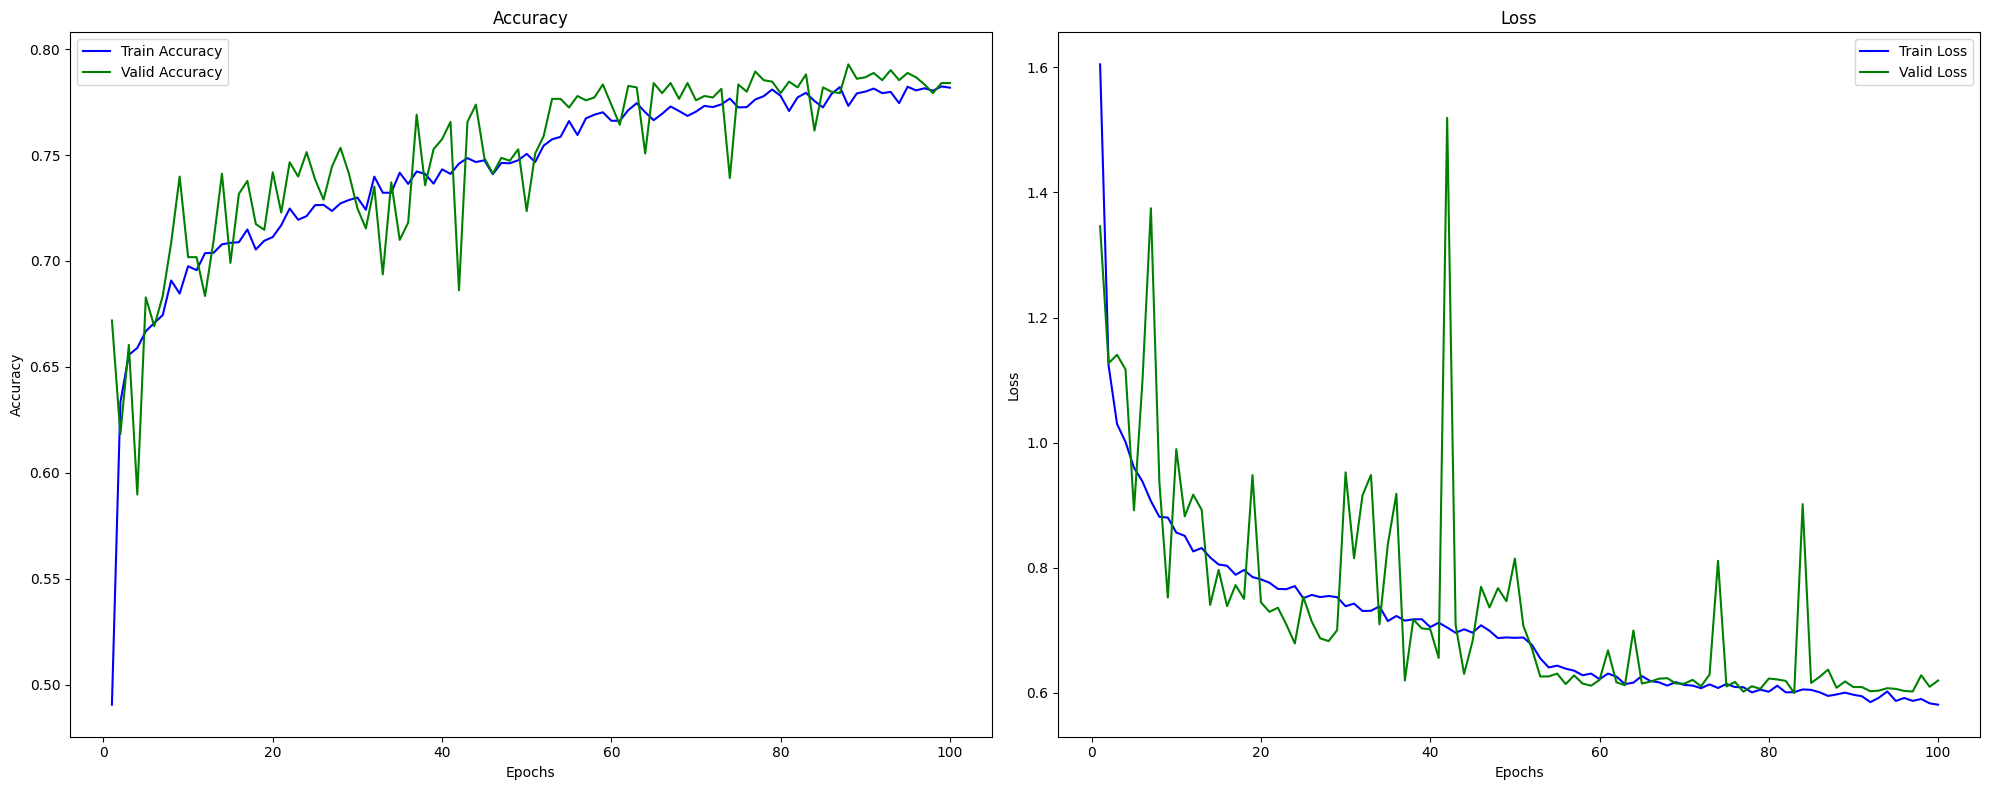

In [22]:
train_acc = history_cnn.history['accuracy']
train_loss = history_cnn.history['loss']
val_acc = history_cnn.history['val_accuracy']
val_loss = history_cnn.history['val_loss']
epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()